In [1]:
import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings 
import math
from ast import literal_eval

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
torch.manual_seed(43)

In [2]:
# training_set = pd.read_csv('../CSV_files/BALL/dataBall_SIFT.csv')
training_set = pd.read_csv('../CSV_files/BALL/dataBall_deepFeatures.csv')
dataSet_len = len(training_set)
print(f"number of frames: {dataSet_len}")
featuresAreCoordinates = False # When False displacement is used as input features
filteredInputs = False
training_set.describe()

number of frames: 98


,scale ratio,volume cm3
count,98.000000,98.000000
mean,0.515000,1070.837938
std,0.284341,1192.321784
min,0.030000,0.074059
25%,0.272500,83.044976
50%,0.515000,564.172160
75%,0.757500,1790.161047
max,1.000000,4122.998900


In [3]:
distance_sensorData = training_set['sensors_e']
x_sensorData = training_set['sensors_x']
y_sensorData = training_set['sensors_y']

In [4]:
def detect_outlier(data_1):
    outliers = []
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [5]:
# filter pre-calculated euclidean distance
filtered_distance = []
filtered_X_distance = []
filtered_Y_distance = []

max_distance = 40
max_Y_distance = 4
max_X_distance = 4

for i in range(len(distance_sensorData)):
    outliers_x, outliers_y, outliers_d = [], [], []
    max_distance *= 1.03
    distance_avg = 0
    distance_list = literal_eval(distance_sensorData[i])
    outliers_d = detect_outlier(distance_list)
    distance_list = [x for x in distance_list if x not in outliers_d if x < max_distance]
    if len(distance_list) > 0:
        distance_avg = sum(distance_list) / len(distance_list)
    filtered_distance.append(distance_avg)

    max_X_distance *= 1.03
    X_distance = 0
    X_list = literal_eval(x_sensorData[i])
    outliers_x = detect_outlier(X_list)
    X_list = [x for x in X_list if x not in outliers_x if x < max_X_distance  if x !=0]
    if len(X_list) > 0:
        X_distance = sum(X_list) / len(X_list)
    filtered_X_distance.append(X_distance)

    max_Y_distance *= 1.03
    Y_distance = 0
    Y_list = literal_eval(y_sensorData[i])
    outliers_y = detect_outlier(Y_list)
    Y_list = [x for x in Y_list if x not in outliers_y if x < max_Y_distance  if x !=0]
    if len(Y_list) > 0:
        Y_distance = sum(Y_list) / len(Y_list)
    filtered_Y_distance.append(Y_distance)

In [6]:
distance_sensorData = [literal_eval(i) for i in training_set['sensors_e']]
x_sensorData = [literal_eval(i) for i in training_set['sensors_x']]
y_sensorData = [literal_eval(i) for i in training_set['sensors_y']]
if featuresAreCoordinates:
    coordinates = [literal_eval(i) for i in training_set['coordinates_src']]
    coordinatesDST = [literal_eval(i) for i in training_set['coordinates_dst']]
    for i in range(len(coordinates)):
        coordinates[i].extend(coordinatesDST[i])

In [7]:
numberOfSensorsList = [len(i) for i in distance_sensorData]
meanOfSensors = sum(numberOfSensorsList)//len(numberOfSensorsList)
maxNumberSensors = max(numberOfSensorsList)
minNumberSensors = min(numberOfSensorsList)

print(f"max amount of sensors: {maxNumberSensors}")
print(f"min amount of sensors: {minNumberSensors}")
print(f"mean amount of sensors: {meanOfSensors}")

max amount of sensors: 98
min amount of sensors: 51
mean amount of sensors: 56


In [8]:
def standardizeSensors(list_sensors, average):
    while len(list_sensors) != average:
        if len(list_sensors) < average:
            list_sensors.append(0.0)
        elif len(list_sensors) > average:
            list_sensors = list_sensors[:average]
    return list_sensors

In [9]:
# trim to normalized number of sensors
distance_sensorData = [standardizeSensors(i, meanOfSensors) for i in distance_sensorData]
x_sensorData = [standardizeSensors(i, meanOfSensors) for i in x_sensorData]
y_sensorData = [standardizeSensors(i, meanOfSensors) for i in y_sensorData]
if featuresAreCoordinates:
    coordinates = [standardizeSensors(i, meanOfSensors*4) for i in coordinates]

In [10]:
# normalize feature information
scFeatures = MinMaxScaler()
distance_sensorData = scFeatures.fit_transform(distance_sensorData)
x_sensorData = scFeatures.fit_transform(x_sensorData)
y_sensorData = scFeatures.fit_transform(y_sensorData)

In [11]:
coordinates_depth = 4
displacement_depth = 3

if featuresAreCoordinates:
    feature_data = np.array(coordinates)
    feature_data = feature_data.reshape(feature_data.shape[0], 1, -1)
else: 
    feature_data = []
    for i in range(dataSet_len):
        feature_data.append([x_sensorData[i], y_sensorData[i], distance_sensorData[i]])
    feature_data = np.array(feature_data)
    feature_data = feature_data.reshape(feature_data.shape[0], 1, -1)

(98, 3, 56)
(98, 1, 168)


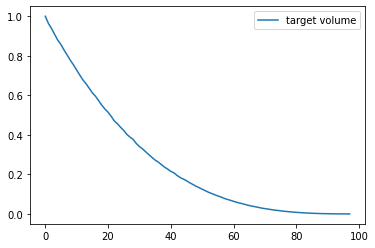

In [12]:
# iloc[row_selection, column_selection]
# can be used to separate between feature data and targets
# feature data: data we watn to learn from
# targets: desired outcome
sc = MinMaxScaler()
target_data = training_set['volume cm3']
df = pd.DataFrame({'volume cm3':target_data, 'euclidean distance': filtered_distance, 'x displacement': filtered_X_distance, 'y displacement':filtered_Y_distance})
training_data = sc.fit_transform(df)
target_data = training_data[:, 0]

if filteredInputs:
    feature_data = training_data[:, 1:]
    plt.plot( feature_data, label = 'feature data')
    feature_data = feature_data.reshape(feature_data.shape[0], 1, -1)
plt.plot( target_data, label = 'target volume')
plt.legend()
plt.show()

In [13]:
df.describe()

,volume cm3,euclidean distance,x displacement,y displacement
count,98.000000,98.000000,98.000000,98.000000
mean,1070.837938,81.148480,-29.597524,-21.513112
std,1192.321784,82.832186,29.071537,28.365082
min,0.074059,0.000000,-217.461538,-72.600000
25%,83.044976,19.762093,-40.857143,-40.361538
50%,564.172160,46.505681,-33.000000,-22.000000
75%,1790.161047,137.646370,-22.000000,0.000000
max,4122.998900,275.317111,33.000000,44.000000


In [14]:
df.head()

,volume cm3,euclidean distance,x displacement,y displacement
0,4122.998900,0.0,0.0,0.0
1,3972.780711,0.0,0.0,0.0
2,3866.722376,0.0,0.0,0.0
3,3742.666032,0.0,0.0,0.0
4,3621.291882,0.0,0.0,0.0


## Dataloading

In [15]:
learning_rate = 0.001
epochs =  500
if featuresAreCoordinates:
    input_size = meanOfSensors*coordinates_depth
else:
    input_size = meanOfSensors*displacement_depth
if filteredInputs:
    input_size = displacement_depth
hidden_size = 2
num_layers = 1
output_size = 1
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size = 0.3, shuffle= True)

dataX = torch.Tensor(feature_data)
dataY = torch.Tensor(target_data)

trainX = torch.Tensor(X_train)
trainY_2Dim = torch.Tensor(y_train)
trainY = trainY_2Dim.view(1, trainY_2Dim.size(0), -1)

testX = torch.Tensor(X_test)
testY_2Dim = torch.Tensor(y_test)
testY = testY_2Dim.view(1, testY_2Dim.size(0), -1)

in RNN, Weights are initialized in the recurrent neural network using normal distribution with zero mean. W1 will represent acceptance of input variables and w2 will represent the output which is generated as shown below.
## Model

In [16]:
class LSTM(nn.Module):

    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # stateless: clean cell state efter every epoch
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [17]:
lstm = LSTM(output_size, input_size, hidden_size, num_layers)
# lstm.load_state_dict(torch.load('MODELS/BALL/ball-LSTM-SIFTDisplacement.pth'))
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [18]:
# Train the model
for epoch in range(epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad() # sets the gradients to zero
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward() # computes the gradients
    
    optimizer.step() #updates the weights
    if epoch % 100 == 0:
        print("Epoch: %d, MSE: %1.5f" % (epoch, loss.item()))
    if epoch == (epochs-1):
        print("MSE:  %1.5f, RMSE: %1.5f" % (loss.item(), math.sqrt(loss.item())))

Epoch: 0, MSE: 0.08160
Epoch: 100, MSE: 0.05066
Epoch: 200, MSE: 0.01889
Epoch: 300, MSE: 0.00420
Epoch: 400, MSE: 0.00175
MSE:  0.00122, RMSE: 0.03494


MSE:  0.00510, RMSE: 0.07138


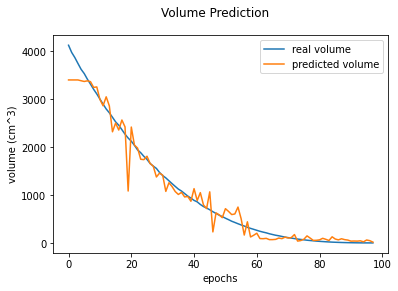

In [20]:
lstm.eval() # sets the model to evaluation mode
test_predict = lstm(testX)
real_loss = criterion(test_predict, testY)
print("MSE:  %1.5f, RMSE: %1.5f" % (real_loss.item(), math.sqrt(real_loss.item())))

train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(target_data), 4) )

# put the predicted values in the right field
trainPredict_dataset_like[:, 0] = data_predict[:,0]
# inverse transform and then select the right field
data_predict = sc.inverse_transform(trainPredict_dataset_like)[:,0]
trainPredict_dataset_like[:, 0] = dataY_plot
dataY_plot = sc.inverse_transform(trainPredict_dataset_like)[:,0]

plt.plot(dataY_plot, label = "real volume")
plt.plot(data_predict, label = "predicted volume")
plt.suptitle('Volume Prediction')
plt.xlabel('epochs')
plt.ylabel('volume (cm^3)')
plt.legend()
plt.show()

In [22]:
#Saving a checkpoint
# torch.save(lstm.state_dict(), 'MODELS/BALL/ball-LSTM-SIFTFiltered.pth')

"\nwith open('../CSV_files/BALL/dataBall_RESULTS.csv', 'w', newline='') as myfile:\n    writer = csv.writer(myfile, quoting=csv.QUOTE_NONNUMERIC, delimiter=',')\n    writer.writerows(results_set)\n"